In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from DeepCNN import DeepCNN

In [2]:
mps_device = torch.device("mps")

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
trainset = torchvision.datasets.FashionMNIST(root='~/datasets/fashionMNIST/', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='~/datasets/fashionMNIST/', train=False, download=True, transform=transform)

In [4]:
batch_size = 128
n_iters = 5000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.001

In [5]:
classes = {0 : 'T-Shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
           4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag',
           9 : 'Ankle boot'}

In [6]:
def calc_validation_loss(model, test_loader):
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.float().to(mps_device)
        labels = labels.to(mps_device)
        
        output = model(images)
        _, predicted = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

    return 100 * (1 - correct / total)

In [7]:
def run_experiment(model):
    
    train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers = 8)
    test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers = 8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    losses = []
    avg_losses = []
    train_errors = []
    val_errors = []

    for epoch in range(num_epochs):
        model = model.train()

        correct = 0
        total = 0
        
        epoch_losses = []

        for i, (images, labels) in enumerate(train_loader, 0):
            images = images.float().to(mps_device)
            labels = labels.to(mps_device)

            # Forward + Backward + Optimizer
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            
            losses.append(loss.cpu().data)
            epoch_losses.append(loss.cpu().data)

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_losses.append(avg_loss)

        train_error = 100 * (1 - correct / total)
        train_errors.append(train_error.cpu().data)
        
        model = model.eval()
        with torch.no_grad():
            val_error = calc_validation_loss(model, test_loader)

        val_errors.append(val_error.cpu().data)

        print ('Epoch : %d/%d, Loss: %.4f, Validation: %.2f %%' %(epoch+1, num_epochs, avg_loss, val_error))

    return train_errors, val_errors

In [8]:
shallow_depth = 15
deep_depth = 25

shallow_standard = DeepCNN(shallow_depth, False).to(mps_device)
deep_standard = DeepCNN(deep_depth, False).to(mps_device)
shallow_residual = DeepCNN(shallow_depth, True).to(mps_device)
deep_residual = DeepCNN(deep_depth, True).to(mps_device)

shallow_standard_train_error, shallow_standard_test_error = run_experiment(shallow_standard)
deep_standard_train_error, deep_standard_test_error = run_experiment(deep_standard)

Epoch : 1/10, Loss: 0.9122, Validation: 40.39 %
Epoch : 2/10, Loss: 0.5659, Validation: 19.56 %
Epoch : 3/10, Loss: 0.4592, Validation: 16.49 %
Epoch : 4/10, Loss: 0.4012, Validation: 14.60 %
Epoch : 5/10, Loss: 0.3637, Validation: 16.16 %
Epoch : 6/10, Loss: 0.3400, Validation: 12.97 %
Epoch : 7/10, Loss: 0.3161, Validation: 13.17 %
Epoch : 8/10, Loss: 0.3003, Validation: 12.91 %
Epoch : 9/10, Loss: 0.2851, Validation: 13.54 %
Epoch : 10/10, Loss: 0.2729, Validation: 12.19 %
Epoch : 1/10, Loss: 2.1220, Validation: 66.22 %
Epoch : 2/10, Loss: 1.3400, Validation: 38.51 %
Epoch : 3/10, Loss: 0.9658, Validation: 35.14 %
Epoch : 4/10, Loss: 0.8615, Validation: 30.63 %
Epoch : 5/10, Loss: 0.7617, Validation: 29.59 %
Epoch : 6/10, Loss: 0.7069, Validation: 27.29 %
Epoch : 7/10, Loss: 0.6910, Validation: 27.63 %
Epoch : 8/10, Loss: 0.6778, Validation: 26.04 %
Epoch : 9/10, Loss: 0.6282, Validation: 22.77 %
Epoch : 10/10, Loss: 0.5948, Validation: 25.02 %


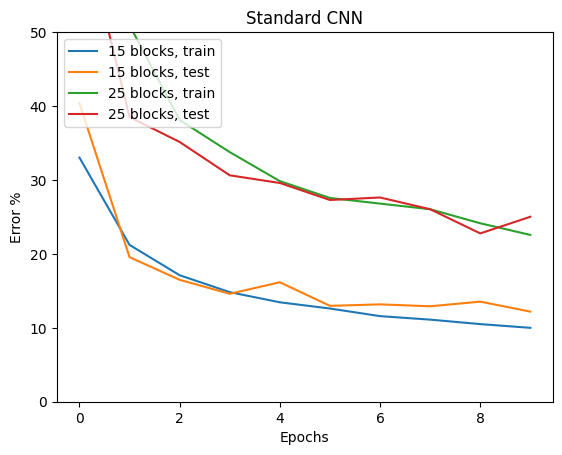

In [9]:
plt.title('Standard CNN')
plt.ylabel('Error %')
plt.xlabel('Epochs')
plt.plot(shallow_standard_train_error)
plt.plot(shallow_standard_test_error)
plt.plot(deep_standard_train_error)
plt.plot(deep_standard_test_error)
plt.ylim(0, 50)

plt.legend(['15 blocks, train', '15 blocks, test', '25 blocks, train', '25 blocks, test'], loc='upper left')

plt.show()

In [10]:
shallow_residual_train_error, shallow_residual_test_error = run_experiment(shallow_residual)
deep_residual_train_error, deep_residual_test_error = run_experiment(deep_residual)

Epoch : 1/10, Loss: 0.9462, Validation: 14.56 %
Epoch : 2/10, Loss: 0.3640, Validation: 11.49 %
Epoch : 3/10, Loss: 0.2896, Validation: 10.37 %
Epoch : 4/10, Loss: 0.2623, Validation: 10.56 %
Epoch : 5/10, Loss: 0.2361, Validation: 10.84 %
Epoch : 6/10, Loss: 0.2164, Validation: 9.69 %
Epoch : 7/10, Loss: 0.2020, Validation: 14.31 %
Epoch : 8/10, Loss: 0.1915, Validation: 10.16 %
Epoch : 9/10, Loss: 0.1797, Validation: 9.20 %
Epoch : 10/10, Loss: 0.1704, Validation: 9.64 %
Epoch : 1/10, Loss: 1.1840, Validation: 17.06 %
Epoch : 2/10, Loss: 0.4041, Validation: 13.15 %
Epoch : 3/10, Loss: 0.3201, Validation: 11.50 %
Epoch : 4/10, Loss: 0.2716, Validation: 10.65 %
Epoch : 5/10, Loss: 0.2490, Validation: 11.00 %
Epoch : 6/10, Loss: 0.2256, Validation: 12.14 %
Epoch : 7/10, Loss: 0.2165, Validation: 10.01 %
Epoch : 8/10, Loss: 0.2018, Validation: 9.47 %
Epoch : 9/10, Loss: 0.1911, Validation: 9.66 %
Epoch : 10/10, Loss: 0.1839, Validation: 9.63 %


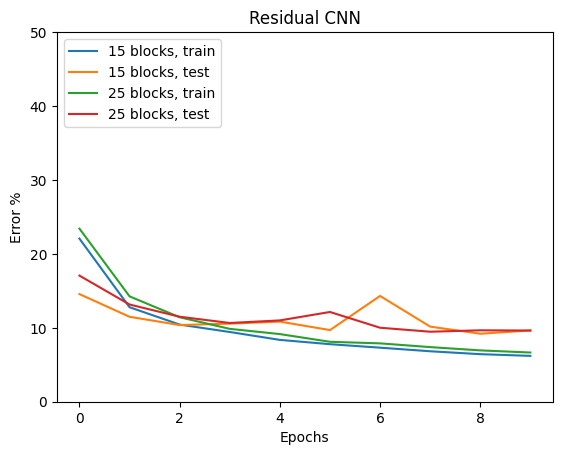

In [11]:
plt.title('Residual CNN')
plt.ylabel('Error %')
plt.xlabel('Epochs')
plt.plot(shallow_residual_train_error)
plt.plot(shallow_residual_test_error)
plt.plot(deep_residual_train_error)
plt.plot(deep_residual_test_error)
plt.ylim(0, 50)

plt.legend(['15 blocks, train', '15 blocks, test', '25 blocks, train', '25 blocks, test'], loc='upper left')

plt.show()